# Quick example of WL Classification
## with CE and using the Moore Penrose inverse as the Virtual Label matrix
This example tries to show the usage of the classes and methods
proposed here to show classification with weakly labeled datasets.
In this case we use the **CE** loss.

In [1]:
# Importing general libraries
import torch
import torch.nn as nn
import torchvision
import numpy as np

# Importing specific classes and functions
from utils.weakener import Weakener

#Importing drawing tools
import matplotlib.pyplot as plt

#importing dataloaders
from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from models.model import MLP
from utils.trainig_testing import train_model,evaluate_model,train_and_evaluate
from utils.losses import EMLoss, CELoss

In [2]:
# DS stores the dataset and its related attributes
DS = Torch_Dataset('mnist')
train_x, train_y, test_x, test_y = DS.get_data()
# WL stores pocesses relative to the Weakening process
WL = Weakener(DS.num_classes)


In [3]:
# Generation of the mixing matrix according to the model
#  we've chosen.
WL.generate_M(model_class='pll')
print(WL.M)
print(WL.labels)

[[0.         0.         0.         ... 0.         0.00217014 0.00217014]
 [0.         0.         0.         ... 0.00217014 0.         0.00217014]
 [0.         0.         0.         ... 0.00217014 0.00217014 0.        ]
 ...
 [0.00195312 0.00195312 0.00195312 ... 0.00195312 0.         0.00195312]
 [0.00195312 0.00195312 0.00195312 ... 0.00195312 0.00195312 0.        ]
 [0.00195312 0.00195312 0.00195312 ... 0.00195312 0.00195312 0.00195312]]
{0: '0000000011', 1: '0000000101', 2: '0000000110', 3: '0000000111', 4: '0000001001', 5: '0000001010', 6: '0000001011', 7: '0000001100', 8: '0000001101', 9: '0000001110', 10: '0000001111', 11: '0000010001', 12: '0000010010', 13: '0000010011', 14: '0000010100', 15: '0000010101', 16: '0000010110', 17: '0000010111', 18: '0000011000', 19: '0000011001', 20: '0000011010', 21: '0000011011', 22: '0000011100', 23: '0000011101', 24: '0000011110', 25: '0000011111', 26: '0000100001', 27: '0000100010', 28: '0000100011', 29: '0000100100', 30: '0000100101', 31: '00

In [4]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
z, w = WL.generate_weak(train_y)

z is the numerical encodig of the weak label while w is a one-hot
representation of that variable. z also encodes the row of the M matrix
for that given weak label.

Let's consider the example of partial label learning for the iris dataset.
labels are encoded as ```{0: '011', 1: '101', 2: '110', 3: '111'}```
so having an isntance with `z=3` means `w=[1,1,1]`, i.e., the weak label contains every label.

In [5]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
WL.virtual_matrix(convex=True)
#And we generate the virtual labels
WL.virtual_labels(train_y)
WL.v[:10,:]


array([[ 0.89727049,  0.89727049, -1.09590574, -1.09590574,  0.89727049,
         0.89727049, -1.09590574,  0.89727049,  0.89727049, -1.09590574],
       [ 1.49521624, -0.49794982, -0.49794982, -0.49794982, -0.49794982,
         1.49521624,  1.49521624, -0.49794982, -0.49794982, -0.49794982],
       [-1.09590574, -1.09590574,  0.89727049,  0.89727049,  0.89727049,
         0.89727049,  0.89727049,  0.89727049, -1.09590574, -1.09590574],
       [ 0.69794982,  0.69794982, -1.29521624,  0.69794982,  0.69794982,
         0.69794982,  0.69794982, -1.29521624, -1.29521624,  0.69794982],
       [-0.89659119,  1.09659119,  1.09659119,  1.09659119, -0.89659119,
        -0.89659119, -0.89659119,  1.09659119, -0.89659119,  1.09659119],
       [-0.89659119,  1.09659119,  1.09659119, -0.89659119,  1.09659119,
         1.09659119,  1.09659119, -0.89659119, -0.89659119, -0.89659119],
       [-1.09590574,  0.89727049,  0.89727049, -1.09590574,  0.89727049,
         0.89727049, -1.09590574,  0.89727049

In [6]:
#We need to include this Weak Labels into the dataset,
# we need to include w to mantain the coherence. z will only be used
# in the loss for the EM
DS.include_weak(WL.v)
# Once we have our dataset with all the labels we need we can create the dataloaders.
trainloader, testloader = DS.get_dataloader()

print(len(testloader.dataset))
print(len(trainloader.dataset))

10000
60000


Now we have a trainloader containing (X,v,y) and a testloader containig (X,y)
so we can just establish our model and train it.

In [7]:
# Create an instance of the MLP class
mlp = MLP(input_size=DS.num_features, hidden_sizes=[20],
          output_size=DS.num_classes, dropout_p=0.5)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

train_losses,train_accs=train_model(mlp,trainloader,optimizer,
                                    loss_fn,num_epochs=10)

# Print the final training loss and accuracy
print('Final Training Loss: {:.4f}'.format(train_losses[-1]))
print('Final Training Accuracy: {:.4f}'.format(train_accs[-1]))

Epoch 1/10 - Loss: 1.3278 - Accuracy: 0.5582
Epoch 2/10 - Loss: 0.9670 - Accuracy: 0.6647
Epoch 3/10 - Loss: 0.8910 - Accuracy: 0.6733
Epoch 4/10 - Loss: 0.7764 - Accuracy: 0.6907
Epoch 5/10 - Loss: 0.7522 - Accuracy: 0.6885
Epoch 6/10 - Loss: 0.7108 - Accuracy: 0.6912
Epoch 7/10 - Loss: 0.6190 - Accuracy: 0.6919
Epoch 8/10 - Loss: 0.5844 - Accuracy: 0.6931
Epoch 9/10 - Loss: 0.5385 - Accuracy: 0.6893
Epoch 10/10 - Loss: 0.4828 - Accuracy: 0.6880
Final Training Loss: 0.4828
Final Training Accuracy: 0.6880


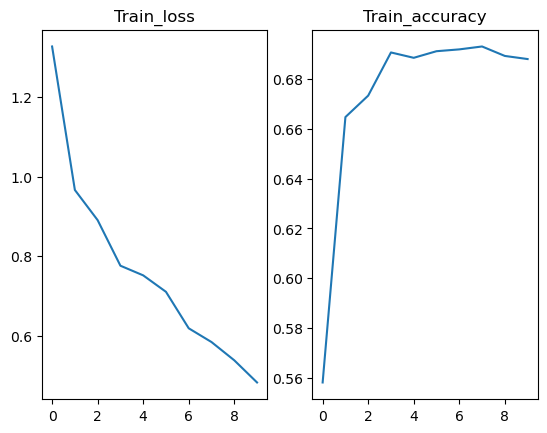

In [8]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(train_losses)
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(train_accs)
axis[1].set_title("Train_accuracy")
plt.show()

In [9]:
# Create an instance of the MLP class
mlp = MLP(input_size=DS.num_features, hidden_sizes=[20],
          output_size=DS.num_classes, dropout_p=0.5)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

# Train and evaluate the MLP on the training data, test data, and get the results
mlp, results = train_and_evaluate(mlp, trainloader, testloader,
                                  optimizer, loss_fn, num_epochs=10)

# Print the results
print('Train Loss:', results['train_loss'][-1])
print('Train Accuracy:', results['train_acc'][-1])
print('Test Accuracy:', results['test_acc'][-1])

Epoch 1/10: Train Loss: 1.4026, Train Acc: 0.5473, Test Acc: 0.8748
Epoch 2/10: Train Loss: 0.9952, Train Acc: 0.6597, Test Acc: 0.8822
Epoch 3/10: Train Loss: 0.8620, Train Acc: 0.6676, Test Acc: 0.8906
Epoch 4/10: Train Loss: 0.8167, Train Acc: 0.6801, Test Acc: 0.8919
Epoch 5/10: Train Loss: 0.7556, Train Acc: 0.6839, Test Acc: 0.8935
Epoch 6/10: Train Loss: 0.6809, Train Acc: 0.6882, Test Acc: 0.8939
Epoch 7/10: Train Loss: 0.6063, Train Acc: 0.6901, Test Acc: 0.8922
Epoch 8/10: Train Loss: 0.5734, Train Acc: 0.6877, Test Acc: 0.8929
Epoch 9/10: Train Loss: 0.5569, Train Acc: 0.6920, Test Acc: 0.8903
Epoch 10/10: Train Loss: 0.5340, Train Acc: 0.6871, Test Acc: 0.8894
Train Loss: 0.5340366625868302
Train Accuracy: tensor(0.6871, dtype=torch.float64)
Test Accuracy: tensor(0.8894, dtype=torch.float64)


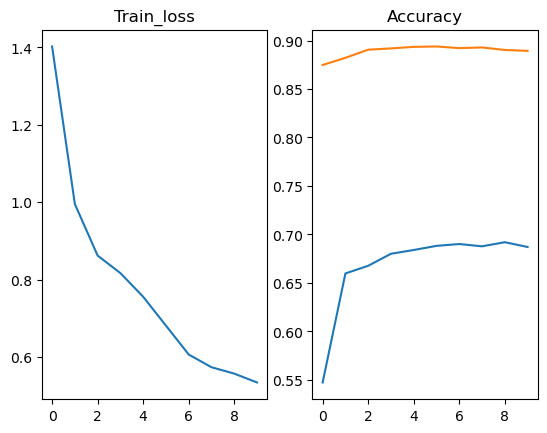

In [10]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(results['train_loss'])
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(results['train_acc'])
axis[1].plot(results['test_acc'])
axis[1].set_title("Accuracy")
plt.show()